- load data
- build labeled iterator
- build validation iterator
- build networks
- load pretrained network
- build PUMAP
- for each epoch
  - build umap graph
  - create data iterator
  - train epoch

In [1]:
# reload packages
%load_ext autoreload
%autoreload 2

### Choose GPU

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=2

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=2


In [3]:
import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if len(gpu_devices)>0:
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
print(gpu_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
tf.keras.backend.clear_session()

### dataset information

In [5]:
from datetime import datetime

dataset = "cifar10"
dims = (32, 32, 3)
umap_prop = 1.0
num_classes = 10
PROJECTION_DIMS = 1024
labels_per_class = 4  #'full'
datestring = datetime.now().strftime("%Y_%m_%d_%H_%M_%S_%f")
datestring = (
    str(dataset)
    + "_"
    + str(umap_prop)
    + "_"
    + str(PROJECTION_DIMS)
    + "_"
    + str(labels_per_class)
    + "____"
    + datestring
    + "__learned-metric_augmented"
)
print(datestring)

cifar10_1.0_1024_4____2020_08_07_09_29_19_672227__learned-metric_augmented


### Load packages

In [6]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
from IPython import display
import pandas as pd
import umap
import copy
import os, tempfile

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


### Load dataset

In [7]:
from tfumap.load_datasets import load_CIFAR10, mask_labels

In [8]:
X_train, X_test, X_valid, Y_train, Y_test, Y_valid = load_CIFAR10(flatten=False)
X_train.shape

(40000, 32, 32, 3)

In [9]:
if labels_per_class == "full":
    X_labeled = X_train
    Y_masked = Y_labeled = Y_train
else:
    X_labeled, Y_labeled, Y_masked = mask_labels(
        X_train, Y_train, labels_per_class=labels_per_class
    )

### Build data iterators

In [10]:
from tfumap.umap import compute_cross_entropy, get_graph_elements
from tfumap.semisupervised import create_edge_iterator, create_validation_iterator, create_classification_iterator

In [11]:
batch_size = 256

In [12]:
img_data_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=10,       # random rotation degrees
    width_shift_range=0.1,   # random shift 10%
    height_shift_range=0.1,
    horizontal_flip=True,
    brightness_range = (0.5, 1.5),
    ##rescale = 0.1,
    zoom_range = 0.2,
    rescale=1./255,  
    #shear_range = 6,
    ##zca_whitening = True,
)

In [13]:
labeled_batch_size = 128
labeled_iter = tf.data.Dataset.from_generator(
    lambda: img_data_gen.flow(X_labeled, y=Y_labeled, batch_size=labeled_batch_size),
    (tf.float32, tf.int32),
).prefetch(10)#.batch(10)

In [14]:
X, y = next(iter(labeled_iter))

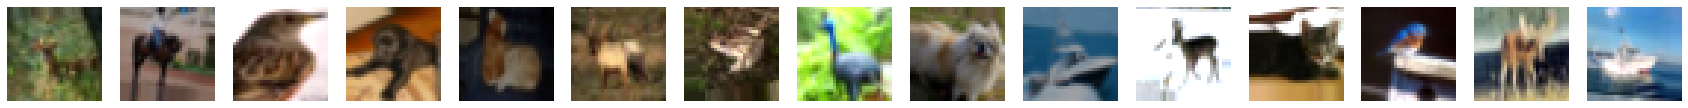

In [15]:
# view augmentations
nex = 15
fig, axs = plt.subplots(ncols=nex, figsize=(nex*2, 2))
for i in range(nex):
    axs[i].imshow(X[i])
    axs[i].axis('off')

In [16]:
data_valid, n_valid_samp = create_validation_iterator(X_valid, Y_valid, batch_size, repeat=True)

### Build network

In [17]:

from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

block_layers_num = 3
weight_decay = 1e-4
name = 'resnet20'
def conv2d_bn(x, filters, kernel_size, weight_decay=.0, strides=(1, 1)):
    layer = Conv2D(filters=filters,
                   kernel_size=kernel_size,
                   strides=strides,
                   padding='same',
                   use_bias=False,
                   kernel_regularizer=l2(weight_decay)
                   )(x)
    layer = BatchNormalization()(layer)
    return layer


def conv2d_bn_relu(x, filters, kernel_size, weight_decay=.0, strides=(1, 1)):
    layer = conv2d_bn(x, filters, kernel_size, weight_decay, strides)
    layer = Activation('relu')(layer)
    return layer


def ResidualBlock(x, filters, kernel_size, weight_decay, downsample=True):
    if downsample:
        # residual_x = conv2d_bn_relu(x, filters, kernel_size=1, strides=2)
        residual_x = conv2d_bn(x, filters, kernel_size=1, strides=2)
        stride = 2
    else:
        residual_x = x
        stride = 1
    residual = conv2d_bn_relu(x,
                              filters=filters,
                              kernel_size=kernel_size,
                              weight_decay=weight_decay,
                              strides=stride,
                              )
    residual = conv2d_bn(residual,
                         filters=filters,
                         kernel_size=kernel_size,
                         weight_decay=weight_decay,
                         strides=1,
                         )
    out = layers.add([residual_x, residual])
    out = Activation('relu')(out)
    return out



input_ = Input(shape=dims)
x =input_
x = conv2d_bn_relu(x, filters=16, kernel_size=(3, 3), weight_decay=weight_decay, strides=(1, 1))

# # conv 2
for i in range(block_layers_num):
    x = ResidualBlock(x, filters=16, kernel_size=(3, 3), weight_decay=weight_decay, downsample=False)
# # conv 3
x = ResidualBlock(x, filters=32, kernel_size=(3, 3), weight_decay=weight_decay, downsample=True)
for i in range(block_layers_num - 1):
    x = ResidualBlock(x, filters=32, kernel_size=(3, 3), weight_decay=weight_decay, downsample=False)
# # conv 4
x = ResidualBlock(x, filters=64, kernel_size=(3, 3), weight_decay=weight_decay, downsample=True)
for i in range(block_layers_num - 1):
    x = ResidualBlock(x, filters=64, kernel_size=(3, 3), weight_decay=weight_decay, downsample=False)
x = AveragePooling2D(pool_size=(8, 8), padding='valid')(x)
x = Flatten()(x)
encoder = Model(input_, x, name=name)

In [18]:
classifier = tf.keras.Sequential()
classifier.add(tf.keras.layers.InputLayer(input_shape=64))
classifier.add(tf.keras.layers.Dense(units=256, activation="relu"))
classifier.add(tf.keras.layers.Dense(units=256, activation="relu"))
classifier.add(tf.keras.layers.Dense(num_classes, activation='softmax', name="predictions"))

In [19]:
encoder.summary()

Model: "resnet20"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 16)   432         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 16)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 16)   0           batch_normalization[0][0]        
___________________________________________________________________________________________

### load weights

In [22]:
from umap import UMAP

In [23]:
from tfumap.paths import MODEL_DIR

In [24]:
load_loc = "cifar10_1.0_1024_4____2020_08_06_15_59_01_968264__learned-metric_augmented"
encoder.load_weights((MODEL_DIR / 'semisupervised' / dataset / load_loc / "encoder").as_posix())
classifier.load_weights((MODEL_DIR / 'semisupervised' / dataset / load_loc / "classifier").as_posix())

In [26]:
def model_data(X, batch_size, model):
    """ embed a set of points in X to Z
    """
    n_batch = int(np.ceil(len(X) / batch_size))
    return np.vstack(
        [
                model(np.array(X[(i) * batch_size : (i + 1) * batch_size, :]))
            for i in tqdm(range(n_batch), leave=False)
        ]
    )

In [28]:
pred_model = tf.keras.models.Model(classifier.input,[classifier.get_layer(name="dense_1").get_output_at(0)])

In [29]:
z_enc = model_data(X_train, 100, encoder)
last_layer_class = model_data(z_enc, batch_size, pred_model)
z_pred = model_data(z_enc, batch_size, classifier)
confidence = np.max(z_pred, axis = 1)
umap_class = UMAP(verbose=True).fit_transform(last_layer_class, Y_masked)
classifications = np.argmax(z_pred, axis=1)
correctness = classifications == Y_train
np.save(MODEL_DIR / 'semisupervised' / dataset / load_loc / 'train_last_layer_class.npy', last_layer_class)
np.save(MODEL_DIR / 'semisupervised' / dataset / load_loc / 'train_z_enc.npy', z_enc)
np.save(MODEL_DIR / 'semisupervised' / dataset / load_loc / 'train_last_layer_class_umap.npy', umap_class)

UMAP(dens_frac=0.0, dens_lambda=0.0, verbose=True)
Construct fuzzy simplicial set
Fri Aug  7 09:31:14 2020 Finding Nearest Neighbors
Fri Aug  7 09:31:14 2020 Building RP forest with 15 trees
Fri Aug  7 09:31:16 2020 parallel NN descent for 15 iterations
	 0  /  15
	 1  /  15
	 2  /  15
Fri Aug  7 09:31:30 2020 Finished Nearest Neighbor Search
Fri Aug  7 09:31:35 2020 Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Aug  7 09:32:04 2020 Finished embedding


Text(0.5, 1.0, 'Correct')

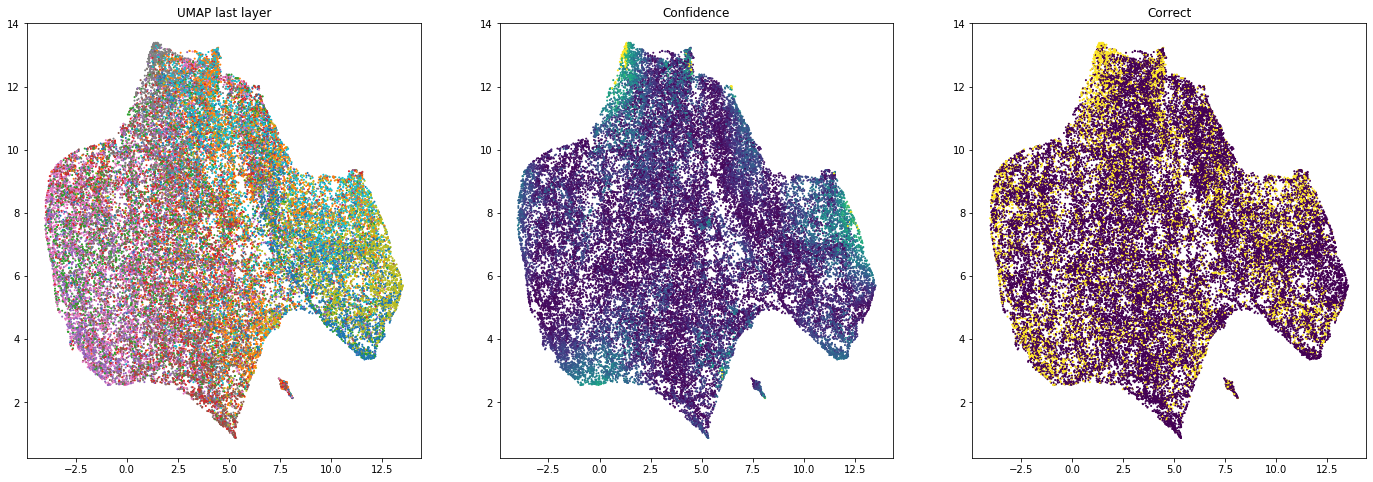

In [30]:
fig, axs = plt.subplots(ncols = 3, figsize=(24,8))
axs[0].scatter(umap_class[:,0], umap_class[:,1], s=1, c = Y_train, cmap = plt.cm.tab10)
axs[0].set_title('UMAP last layer')
axs[1].scatter(umap_class[:,0], umap_class[:,1], s=1, c = np.log(1-confidence + 1e-10), cmap = plt.cm.viridis_r)
axs[1].set_title('Confidence')
axs[2].scatter(umap_class[:,0], umap_class[:,1], s=1, c = correctness, cmap = plt.cm.viridis)
axs[2].set_title('Correct')